<font size=10>Laboratory Assignment 3.1</font>

# Introduction
In this laboratory, we will cover the basic element of programming using a map-reduce methodology. For that purpose, we will be using Apache Spark as a reference, but bear in mind that similar frameworks exists and principles can be extrapolated.

## Some concepts and facts

- Spark is a distributed computing platform that operates on a cluster. Like MPI, we expect that nodes does NOT share a memory space but they are connected in high-speed dedicated network. Distributed filesystems that work over the network are extremely useful.

- It is considered the next generation of previous map-reduce standard Apache Hadoop. Main difference is thought to be the use of the memory instead of disk for intermediate operations, but there are many more improvements.

- It is built on Java. Despite this, it can be programmed using Java, Scala, Python or R. The complete API can only be found in JVM-based languages but the most frequent one is PySpark, since people is reluctant to use JVM-based languages in data science. Indeed, since Hadoop was only available for Java, it is likely that some Java codes of Spark are adaptations of previous Hadoop codes.

- Resilient Distributed Dataset (RDD): the basic unit that is processed in Spark. Equivalent to a numpy array but distributed.

- RDD API usually exposes the low-level operations of Apache Spark, useful for preprocessing data but useless for data analytics

- For data analysis, Dataframe and Spark SQL is used. It relies on a pandas-alike API that even accepts SQL code (which may sound crazy and useless for developers, but many *old* data scientists and statisticians are really proficient in SQL but not in Python).

## How to install Spark in colab.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install JVM v8
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz # Download latest release. Update if necessary
!tar xf spark-2.4.5-bin-hadoop2.7.tgz # Unzip
!pip install pyspark==2.4.5 # Well, the library itself
!pip install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217.8 MB 7.0 kB/s 
     |████████████████████████████████| 197 kB 41.8 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=539a5f0892ec35be5a8aefe91f95228e0cdf0f54acd7483182dc47b684e8026b
  Stored in directory: /root/.cache/pip/wheels/01/c0/03/1c241c9c482b647d4d99412a98a5c7f87472728ad41ae55e1e
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## How to initialize Spark

In [3]:
from pyspark.sql import SparkSession
import findspark
findspark.init("/content/spark-2.4.5-bin-hadoop2.7") 

APP_NAME = "CAP-lab3"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sc = spark.sparkContext

# First Part: RDDs

## Basic operations

### Parallelize & collect

It creates a RDD out of a list or array. Second argument indicates the number of pieces of the RDD

In [4]:
array = sc.parallelize([1,2,3,4,5,6,7,8,9,10], 2)
array

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195

In [5]:
import numpy as np
randomSamples = sc.parallelize(np.random.randn(100))
randomSamples

ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:195

Cool, RDDs can not be printed...

Of course, RDDs can not be printed unless they are reduced

In [6]:
print(array.collect())
print(randomSamples.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.02081312770417299, 1.4104284925882355, 0.8692107989388611, -1.0890152630777783, 1.5491387285151792, 0.4486187582155749, -0.3633169114646556, -0.31383411905222375, -0.8130830529640949, -0.6381562440428721, 0.7923174764161577, 0.11043108999246631, 0.5588643594971425, -0.21430118742908685, 1.1562181372767564, -0.15762347259252524, 0.29220515619539006, -0.9399142594827479, -0.07978484062438808, 0.5278661421697606, 0.9471211851600524, 0.17619005339826568, 1.5179328679809443, -1.0038978622466572, -0.37241757203415077, -0.913222669748608, -0.881540708060972, -0.22827264877410966, -1.0566815995142138, -1.54320025664275, -0.36058989181959705, -0.5593370253829703, 2.2722849714723874, -0.32313023736323754, 0.8016995796925477, 0.6046263926174474, -0.37018217761645394, 0.926037813716803, 1.250183071506194, 1.3657471836390092, -0.06441998239741079, -1.9985891231471389, -0.05411642213480359, -1.8470937090845976, 0.5428847328579228, -0.9063967810229695, 0.59623607123

Spark uses lazy operations for everything, this means that nothing is evaluated until an action, a reduce operation normally, is performed. The basic reduce operation is collect, which returns the whole RDD (i.e. no reduction is performed).

### Other ways of loading data

In [7]:
import requests

request = requests.get("https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt")
with open("elquijote.txt", "wb") as f:
  f.write(request.content) 

In [8]:
quijote = sc.textFile("elquijote.txt")
quijote.take(4)

['DON QUIJOTE DE LA MANCHA',
 'Miguel de Cervantes Saavedra',
 '',
 'PRIMERA PARTE']

Here, you can see both a method to load a text file line per line and a another reduction operation.

In [9]:
quijote.take?

### Transformations

Let's review all the transformation that can be performed to data.

In [10]:
charsPerLine = quijote.map(lambda s: len(s))
allWords = quijote.flatMap(lambda s: s.split())
allWordsNoArticles = allWords.filter(lambda a: a.lower() not in ["el", "la"])
allWordsUnique = allWords.map(lambda s: s.lower()).distinct()
sampleWords = allWords.sample(withReplacement=True, fraction=0.2, seed=666)
weirdSampling = sampleWords.union(allWordsNoArticles.sample(False, fraction=0.3))

In [11]:
allWordsUnique.take(10)

['don',
 'mancha',
 'saavedra',
 'primera',
 'parte',
 '1:',
 'que',
 'condición',
 'y',
 'del']

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each operation above.

Comment also on the size of the resulting RDD in terms of the size of the original RDD, e.g. if original RDD is of size $N$, then rdd.filter() is of size $K\leq N$

--------
Answer:
- map: applies a transformation where K = N, in the example it applies len() to all lines
- flatMap: transformation where K >= N, in example it splits the lines into words
- filter: transformation where K <= N, in example we extract all words that are not articles
- distinct: transformation where K <= N, in example extract all unique words
- sample: transformation where K <= N
- union: transformation where K >= N, it unites 2 RDDs

----

 ### Actions

 

In [12]:
numLines = quijote.count()
numChars = charsPerLine.reduce(lambda a,b: a+b) # also charsPerLine.sum()
sortedWordsByLength = allWordsNoArticles.takeOrdered(5, key=lambda x: -len(x))
numLines, numChars, sortedWordsByLength

(2186,
 1036211,
 ['procuremos.Levántate,',
  'extraordinariamente,',
  'estrechísimamente,',
  'convirtiéndoseles',
  'entretenimientos,'])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the count operation using reduce as the unique option. You can use transformations. Is it possible to achieve a solution without any transformation? Does it make sense?

--------
Answer:
- count: counts the elements of an RDD
- reduce: applies a function to elements of RDD until it is reduced to 1
- takeOrdered: it orders the data by a given function, output is same size as input

Isn't count() an action not making use of transformations?

In [13]:
quijote.map(lambda a: 1).reduce(lambda a,b: a+b)

2186

----

## Key-Value RDDs

In [14]:
import re
allWords = allWords.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.lower()).split(" ")).filter(lambda a: len(a)>0)
allWords2 = sc.parallelize(requests.get("https://gist.githubusercontent.com/jsdario/9d871ed773c81bf217f57d1db2d2503f/raw/585de69b0631c805dabc6280506717943b82ba4a/el_quijote_ii.txt").iter_lines())
allWords2 = allWords2.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.decode("utf8").lower()).split(" ")).filter(lambda a: len(a)>0)

In [15]:
allWords.take(10), allWords2.take(10)

(['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'primera'],
 ['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'segunda'])

Next, we move to more interesting operations that involve key-value RDDs. Key-value RDDs are a special kind of RDDs where each is element is a tuple (K,V) where K is the key and V the value.

In [18]:
words = allWords.map(lambda e: (e,1))
words2 = allWords2.map(lambda e: (e,1))

words.take(10), words2.take(10)

([('don', 1),
  ('quijote', 1),
  ('de', 1),
  ('la', 1),
  ('mancha', 1),
  ('miguel', 1),
  ('de', 1),
  ('cervantes', 1),
  ('saavedra', 1),
  ('primera', 1)],
 [('don', 1),
  ('quijote', 1),
  ('de', 1),
  ('la', 1),
  ('mancha', 1),
  ('miguel', 1),
  ('de', 1),
  ('cervantes', 1),
  ('saavedra', 1),
  ('segunda', 1)])

### How to manipulate K-V RDDs

In [19]:
frequencies = words.reduceByKey(lambda a,b: a+b)
frequencies2 = words2.reduceByKey(lambda a,b: a+b)
frequencies.takeOrdered(10, key=lambda a: -a[1])

[('que', 10705),
 ('de', 9033),
 ('y', 8668),
 ('la', 5015),
 ('a', 4815),
 ('en', 4046),
 ('el', 3857),
 ('no', 3083),
 ('se', 2382),
 ('los', 2148)]

In [24]:
res = words.groupByKey().takeOrdered(10, key=lambda a: -len(a))
res # To see the content, res[i][1].data

[('don', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1510>),
 ('mancha', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1990>),
 ('saavedra', <pyspark.resultiterable.ResultIterable at 0x7fafeacd19d0>),
 ('primera', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1610>),
 ('parte', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1890>),
 ('1', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1d90>),
 ('que', <pyspark.resultiterable.ResultIterable at 0x7fafeacd10d0>),
 ('condición', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1f90>),
 ('y', <pyspark.resultiterable.ResultIterable at 0x7fafeacd1d50>),
 ('del', <pyspark.resultiterable.ResultIterable at 0x7fafeacfbd90>)]

In [26]:
joinFreq = frequencies.join(frequencies2)
joinFreq.take(10)

[('don', (1072, 1606)),
 ('mancha', (50, 101)),
 ('saavedra', (2, 1)),
 ('primera', (39, 55)),
 ('parte', (178, 158)),
 ('1', (1, 1)),
 ('que', (10705, 10040)),
 ('condición', (33, 39)),
 ('y', (8668, 9650)),
 ('del', (1128, 1344))]

In [ ]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1])
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the frequency with groupByKey and transformations.

Which of the two following cells is more efficient?

--------
Answer:
 - reduceByKey: count the occurance of each key and outputs a new dict with (key, count)
 - groupByKey: groups all values of multiple occuring keys returns a new dict with (key, RDD)
 - takeOrdered: takes the first x elements of a key ordered by a given expression over the values
 - join: joins two dicts on their keys, returns dict with (key, (val1, val2))


The joinFreq indicates in wich of the 2 texts the word is occuring more often, 1 signifies greater occurance in Text1, 0 is equal occurance and -1 is greater occurance in Text2

In [63]:
frequencies_own = words.groupByKey().map(lambda e: (e[0],len(e[1])))
frequencies.takeOrdered(10, key=lambda a: -a[1]), frequencies_own.takeOrdered(10, key=lambda a: -a[1])

([('que', 10705),
  ('de', 9033),
  ('y', 8668),
  ('la', 5015),
  ('a', 4815),
  ('en', 4046),
  ('el', 3857),
  ('no', 3083),
  ('se', 2382),
  ('los', 2148)],
 [('que', 10705),
  ('de', 9033),
  ('y', 8668),
  ('la', 5015),
  ('a', 4815),
  ('en', 4046),
  ('el', 3857),
  ('no', 3083),
  ('se', 2382),
  ('los', 2148)])

------

In [64]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1])
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

[('teresa', -0.9767441860465116),
 ('roque', -0.96),
 ('refranes', -0.9375),
 ('condesa', -0.9333333333333333),
 ('leones', -0.9333333333333333),
 ('gobernadores', -0.9166666666666666),
 ('lacayo', -0.9166666666666666),
 ('visorrey', -0.9130434782608695),
 ('antonio', -0.9076923076923077),
 ('zaragoza', -0.9047619047619048)]

In [65]:
result = joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1])))
result.takeOrdered(10, lambda v: -v[1]), result.takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

## Optimizations and final notes

### Optimizing the data movement around the cluster

One of the main issues could be that if data after an operation is not balanced, we may not be using the cluster properly. For that purpose, we have two operations


In [75]:
result.coalesce(numPartitions=2) # Avoids the data movement, so it tries to balance inside each machine
result.repartition(numPartitions=2) # We don't care about data movement, this balance the whole thing to ensure all machines are used


MapPartitionsRDD[257] at coalesce at NativeMethodAccessorImpl.java:0

### Persistance for intermediate operations
In contrast to Hadoop, intermediate RDDs are not preserved, each time we use an action/reduction, the whole data pipeline is executed from the datasources. To avoid this:


In [67]:
result.take(10)
allWords.cache() # allWords RDD must  stay in memory after computation, we made a checkpoint (well, it's a best effort, so must might be too strong)
result.take(10)

[('don', -0.19940253920836445),
 ('mancha', -0.33774834437086093),
 ('saavedra', 0.3333333333333333),
 ('primera', -0.1702127659574468),
 ('parte', 0.05952380952380952),
 ('1', 0.0),
 ('que', 0.03205591708845505),
 ('condición', -0.08333333333333333),
 ('y', -0.05360847254067038),
 ('del', -0.08737864077669903)]

In [82]:
from pyspark import StorageLevel
# https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#rdd-persistence
allWords2.persist(StorageLevel.MEMORY_AND_DISK) # Now it will be preserved on disk also

PythonRDD[240] at RDD at PythonRDD.scala:53

In [83]:
!rm -rf palabras_parte2
allWords2.coalesce(numPartitions=1)
allWords2.saveAsTextFile("palabras_parte2")

In [84]:
!ls -l palabras_parte2

total 1076
-rw-r--r-- 1 root root 666813 Nov 27 15:11 part-00000
-rw-r--r-- 1 root root 430302 Nov 27 15:11 part-00001
-rw-r--r-- 1 root root      0 Nov 27 15:11 _SUCCESS


--------


<font size=10 color=red>Assignment question</font>

Before saving with saveAsTextFile, use coalesce with different values. What's the difference in the previous ls? 

--------
Answer:
 - It does not seem to have any effect on the format of the saved data.
 
 The data probably just gets split into multiple files by size.

 When loading the data it will get distributed onto machines again without recovering old distributions.

----

### Global variables

There are two kind of global variables, read-only and write-only.

In [85]:
articles = sc.broadcast(["el", "la"])
articles.value

['el', 'la']

Broadcast variables are read-only. They help us to avoid local variables of the closures (the functions we use inside map, reduce, ...) to be transferred in every single Spark operation. In that way, they are only transferred only once.

In [86]:
acc = sc.accumulator(0)
def incrementar(x):
  global acc
  acc += x

allWords.map(lambda l:1).foreach(incrementar)
acc

Accumulator<id=0, value=187045>

Write-only variables can be also declared and initialized, but they can not be read since reading will force a complete synchronization of the cluster.

# Second part: Spark SQL

Next, we will do a short review of the high-level API of Spark

In [240]:
import pandas as pd

size = int(1e6)
def loadRedditToPandas(subreddit=None, size=size):
  if subreddit is not None:
    print(subreddit)
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&sort=desc&sort_type=created_utc&size={size:d}").json()
  else:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?sort=desc&sort_type=created_utc&size={size:d}").json()
  return pd.DataFrame(redditData["data"])

In [ ]:
pdf = loadRedditToPandas()
pdf.head(10)

In [ ]:
pdf.selftext = pdf.selftext.apply(lambda e: str(e))

In [94]:
attrs = ["author", "created_utc", "title", "subreddit", "selftext", "over_18"]
df = spark.createDataFrame(pdf[attrs])

## Basic operations

In [95]:
df.show()

+-----------------+-----------+--------------------+-----------------+--------------------+-------+
|           author|created_utc|               title|        subreddit|            selftext|over_18|
+-----------------+-----------+--------------------+-----------------+--------------------+-------+
| troybradshaw1482| 1669562550|r/0fvsd5qkhkptwrx...|  0fvsd5qkhkptwrx|A place for membe...|  false|
|       blewis8550| 1669562550|r/tg1qlp8stsujn0w...|  tg1qlp8stsujn0w|A place for membe...|  false|
|        jhargis91| 1669562550|         What if????|   LosAngelesRams|As an STL Rams fa...|  false|
|   courtney968716| 1669562550|r/symujrg95hpnz8f...|  symujrg95hpnz8f|A place for membe...|  false|
|patricialozano508| 1669562550|r/nfw043doqrgldso...|  nfw043doqrgldso|A place for membe...|  false|
|  stephanie632910| 1669562550|r/4ole7etxplkie48...|  4ole7etxplkie48|A place for membe...|  false|
|      xtaylor8554| 1669562550|r/ffoybq5yqc0mm3v...|  ffoybq5yqc0mm3v|A place for membe...|  false|


### Filtering

In [98]:
df.filter(~df.over_18).show()

+-----------------+-----------+--------------------+-----------------+--------------------+-------+
|           author|created_utc|               title|        subreddit|            selftext|over_18|
+-----------------+-----------+--------------------+-----------------+--------------------+-------+
| troybradshaw1482| 1669562550|r/0fvsd5qkhkptwrx...|  0fvsd5qkhkptwrx|A place for membe...|  false|
|       blewis8550| 1669562550|r/tg1qlp8stsujn0w...|  tg1qlp8stsujn0w|A place for membe...|  false|
|        jhargis91| 1669562550|         What if????|   LosAngelesRams|As an STL Rams fa...|  false|
|   courtney968716| 1669562550|r/symujrg95hpnz8f...|  symujrg95hpnz8f|A place for membe...|  false|
|patricialozano508| 1669562550|r/nfw043doqrgldso...|  nfw043doqrgldso|A place for membe...|  false|
|  stephanie632910| 1669562550|r/4ole7etxplkie48...|  4ole7etxplkie48|A place for membe...|  false|
|      xtaylor8554| 1669562550|r/ffoybq5yqc0mm3v...|  ffoybq5yqc0mm3v|A place for membe...|  false|


In [99]:
df.where(~df.over_18).show()

+-----------------+-----------+--------------------+-----------------+--------------------+-------+
|           author|created_utc|               title|        subreddit|            selftext|over_18|
+-----------------+-----------+--------------------+-----------------+--------------------+-------+
| troybradshaw1482| 1669562550|r/0fvsd5qkhkptwrx...|  0fvsd5qkhkptwrx|A place for membe...|  false|
|       blewis8550| 1669562550|r/tg1qlp8stsujn0w...|  tg1qlp8stsujn0w|A place for membe...|  false|
|        jhargis91| 1669562550|         What if????|   LosAngelesRams|As an STL Rams fa...|  false|
|   courtney968716| 1669562550|r/symujrg95hpnz8f...|  symujrg95hpnz8f|A place for membe...|  false|
|patricialozano508| 1669562550|r/nfw043doqrgldso...|  nfw043doqrgldso|A place for membe...|  false|
|  stephanie632910| 1669562550|r/4ole7etxplkie48...|  4ole7etxplkie48|A place for membe...|  false|
|      xtaylor8554| 1669562550|r/ffoybq5yqc0mm3v...|  ffoybq5yqc0mm3v|A place for membe...|  false|


In [100]:
df.where("not over_18").show() # SQL syntax

+-----------------+-----------+--------------------+-----------------+--------------------+-------+
|           author|created_utc|               title|        subreddit|            selftext|over_18|
+-----------------+-----------+--------------------+-----------------+--------------------+-------+
| troybradshaw1482| 1669562550|r/0fvsd5qkhkptwrx...|  0fvsd5qkhkptwrx|A place for membe...|  false|
|       blewis8550| 1669562550|r/tg1qlp8stsujn0w...|  tg1qlp8stsujn0w|A place for membe...|  false|
|        jhargis91| 1669562550|         What if????|   LosAngelesRams|As an STL Rams fa...|  false|
|   courtney968716| 1669562550|r/symujrg95hpnz8f...|  symujrg95hpnz8f|A place for membe...|  false|
|patricialozano508| 1669562550|r/nfw043doqrgldso...|  nfw043doqrgldso|A place for membe...|  false|
|  stephanie632910| 1669562550|r/4ole7etxplkie48...|  4ole7etxplkie48|A place for membe...|  false|
|      xtaylor8554| 1669562550|r/ffoybq5yqc0mm3v...|  ffoybq5yqc0mm3v|A place for membe...|  false|


### Operations



In [101]:
df.select(df.created_utc * 2).show()

+-----------------+
|(created_utc * 2)|
+-----------------+
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
|       3339125100|
+-----------------+
only showing top 20 rows



In [102]:
from pyspark.sql.functions import log
df.select(log(df.created_utc * 2)).show()

+----------------------+
|LOG((created_utc * 2))|
+----------------------+
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
|     21.92897466351336|
+----------------------+
only showing top 20 rows



### Aggregations



In [103]:
df.where("not over_18").groupby(["author", df.subreddit]).count().toPandas()

,author,subreddit,count
0,BabyKraken1999,investing,1
1,k3nnfucius,Sneakers,1
2,phnewsfeed,phnewsfeed,1
3,sozar12,programming,1
4,clara76__1,SugarMomma_82736,1
...,...,...,...
164,VM_LOTR_2020,WriteStreakIT,1
165,aglover8558,7n8pru2pemn4a9q,1
166,pro_chess,u_pro_chess,1
167,courtney968716,symujrg95hpnz8f,1


### Custom functions

In [104]:
from pyspark.sql.functions import length

df = df.withColumn("length", length(df.selftext)) # This adds a column

df.where("length > 1000").toPandas()

,author,created_utc,title,subreddit,selftext,over_18,length
0,loveisintheairrrrr,1669562549,F35 got fucked by a younger guy at the beach w...,SluttyConfessions,\n\n\n\n\n\nI was in a resort with my son in t...,True,1181
1,uclamutt,1669562547,How do I set up ‘watch only’ Blue wallet that ...,coldcard,I have a Coldcard that I use with sparrow on m...,False,1053
2,trans-ghost-boy-2,1669562545,How do I realistically portray severe trauma w...,writingadvice,"In a roleplay server I’m on, one of my charact...",False,1044
3,VegetableWeird7500,1669562544,A game about shapes,gameideas,Hello everyone ! I've thought about a new idea...,False,1690
4,dddf34,1669562542,Maid of honor wants to be in white/light pink,weddingplanning,"Hi wonderful people,\n\nFirst of all I am not ...",False,1320


In [105]:
from pyspark.sql.functions import udf

def splitWords(e):
  return e.split(" ")

splitWords = udf(splitWords)
df.select(splitWords(df.selftext)).show()

+--------------------+
|splitWords(selftext)|
+--------------------+
|[A, place, for, m...|
|[A, place, for, m...|
|[As, an, STL, Ram...|
|[A, place, for, m...|
|[A, place, for, m...|
|[A, place, for, m...|
|[A, place, for, m...|
|[A, place, for, m...|
|[A, place, for, m...|
|[A, place, for, m...|
|[Ya, tengo, el, R...|
|[A, place, for, m...|
|[A, place, for, m...|
|                  []|
|                  []|
|[A, place, for, m...|
|[A, place, for, m...|
|                  []|
|[A, place, for, m...|
|                  []|
+--------------------+
only showing top 20 rows



--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 1k posts in any subreddit

--------
Answer: Below is the query to obtain all authors with more than 2 posts, accumulated only over the last 80k posts.

For this exercise it is not feasable to obtain the posts of all time

-----

In [165]:
df2 = spark.createDataFrame(loadRedditToPandas(size=80000)[["author", "created_utc", "title", "subreddit", "selftext"]])
over_1k = df2.groupby("author").count().where("count > 2")
over_1k.toPandas().head(10)

## SQL operations

### How to declare a view from a Dataframe

In [166]:
df.createOrReplaceTempView("reddit")

In [167]:
spark.sql("select * from reddit limit 10").show()

+-----------------+-----------+--------------------+---------------+--------------------+-------+------+
|           author|created_utc|               title|      subreddit|            selftext|over_18|length|
+-----------------+-----------+--------------------+---------------+--------------------+-------+------+
| troybradshaw1482| 1669562550|r/0fvsd5qkhkptwrx...|0fvsd5qkhkptwrx|A place for membe...|  false|    64|
|       blewis8550| 1669562550|r/tg1qlp8stsujn0w...|tg1qlp8stsujn0w|A place for membe...|  false|    64|
|        jhargis91| 1669562550|         What if????| LosAngelesRams|As an STL Rams fa...|  false|   785|
|   courtney968716| 1669562550|r/symujrg95hpnz8f...|symujrg95hpnz8f|A place for membe...|  false|    64|
|patricialozano508| 1669562550|r/nfw043doqrgldso...|nfw043doqrgldso|A place for membe...|  false|    64|
|  stephanie632910| 1669562550|r/4ole7etxplkie48...|4ole7etxplkie48|A place for membe...|  false|    64|
|      xtaylor8554| 1669562550|r/ffoybq5yqc0mm3v...|ffo

--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 1k characters in any subreddit with SQL (without using any column named length)

--------
Answer:

In [220]:
from pyspark.sql.types import *
length = udf(lambda z: len(z), IntegerType())

df.select(["author", length(df.selftext)]).groupBy("author").sum().show()

# could not filter for > 1000 characters.
# how is it possible without an extra column at some point??

+--------------------+-----------------------+
|              author|sum(<lambda>(selftext))|
+--------------------+-----------------------+
|           jhargis91|                    785|
|           MandM1619|                    314|
|   CapitalSector6958|                    209|
|   thegodhandcomplex|                      0|
|  loveisintheairrrrr|                   1181|
|SilentImprovement629|                      0|
|  NeilCollinsRecords|                      0|
|      WifeLuvsPosing|                      0|
|    sandersmaria3157|                     64|
|         Apprehen001|                    643|
|       CasualGameBoi|                    290|
|          gaywallbug|                      9|
|Traditional_Rain_572|                      0|
|            L3wdyBoi|                    262|
|            hducdxhd|                      0|
|   phillipssusan1267|                     64|
|       wolfecarol832|                     64|
|            gm255808|                     92|
|            

----

## Other libraries

Beyond dataframes, we can find other libraries that also rely on Spark...

In [221]:
!pip install koalas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 390 kB 4.9 MB/s 


In [222]:
import databricks.koalas as ks
import pandas as pd

# Create a Koalas DataFrame from pandas DataFrame
kdf = ks.from_pandas(pdf[attrs])

kdf.head()

,author,created_utc,title,subreddit,selftext,over_18
0,troybradshaw1482,1669562550,r/0fvsd5qkhkptwrx Lounge,0fvsd5qkhkptwrx,A place for members of r/0fvsd5qkhkptwrx to ch...,False
1,blewis8550,1669562550,r/tg1qlp8stsujn0w Lounge,tg1qlp8stsujn0w,A place for members of r/tg1qlp8stsujn0w to ch...,False
2,jhargis91,1669562550,What if????,LosAngelesRams,As an STL Rams fan ever since the rams moved I...,False
3,courtney968716,1669562550,r/symujrg95hpnz8f Lounge,symujrg95hpnz8f,A place for members of r/symujrg95hpnz8f to ch...,False
4,patricialozano508,1669562550,r/nfw043doqrgldso Lounge,nfw043doqrgldso,A place for members of r/nfw043doqrgldso to ch...,False


In [223]:
kdf["sumChars"] = kdf.selftext.str.len()
res = kdf.groupby(["author", "subreddit"]).sum()
res[res.sumChars > 1000]

,,created_utc,sumChars
author,subreddit,,
dddf34,weddingplanning,1669562542,1320
uclamutt,coldcard,1669562547,1053
trans-ghost-boy-2,writingadvice,1669562545,1044
loveisintheairrrrr,SluttyConfessions,1669562549,1181
VegetableWeird7500,gameideas,1669562544,1690


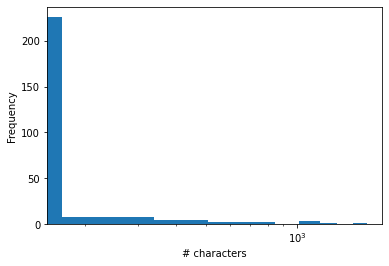

In [224]:
import matplotlib.pyplot as plt
plt.hist(res.sumChars.to_numpy())
plt.xlabel("# characters")
plt.ylabel("Frequency")
plt.xscale("log")

In [225]:
!curl https://2.bp.blogspot.com/-eGskF3n8_Ag/XE7F3P_de2I/AAAAAAAAHU8/WJw0un2nHqMGA8cFVtv_yFfpBVQJSYyVACK4BGAYYCw/s1600/Icon-Reddit.png > reddit.png
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open("reddit.png"))
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76154  100 76154    0     0  1690k      0 --:--:-- --:--:-- --:--:-- 1690k


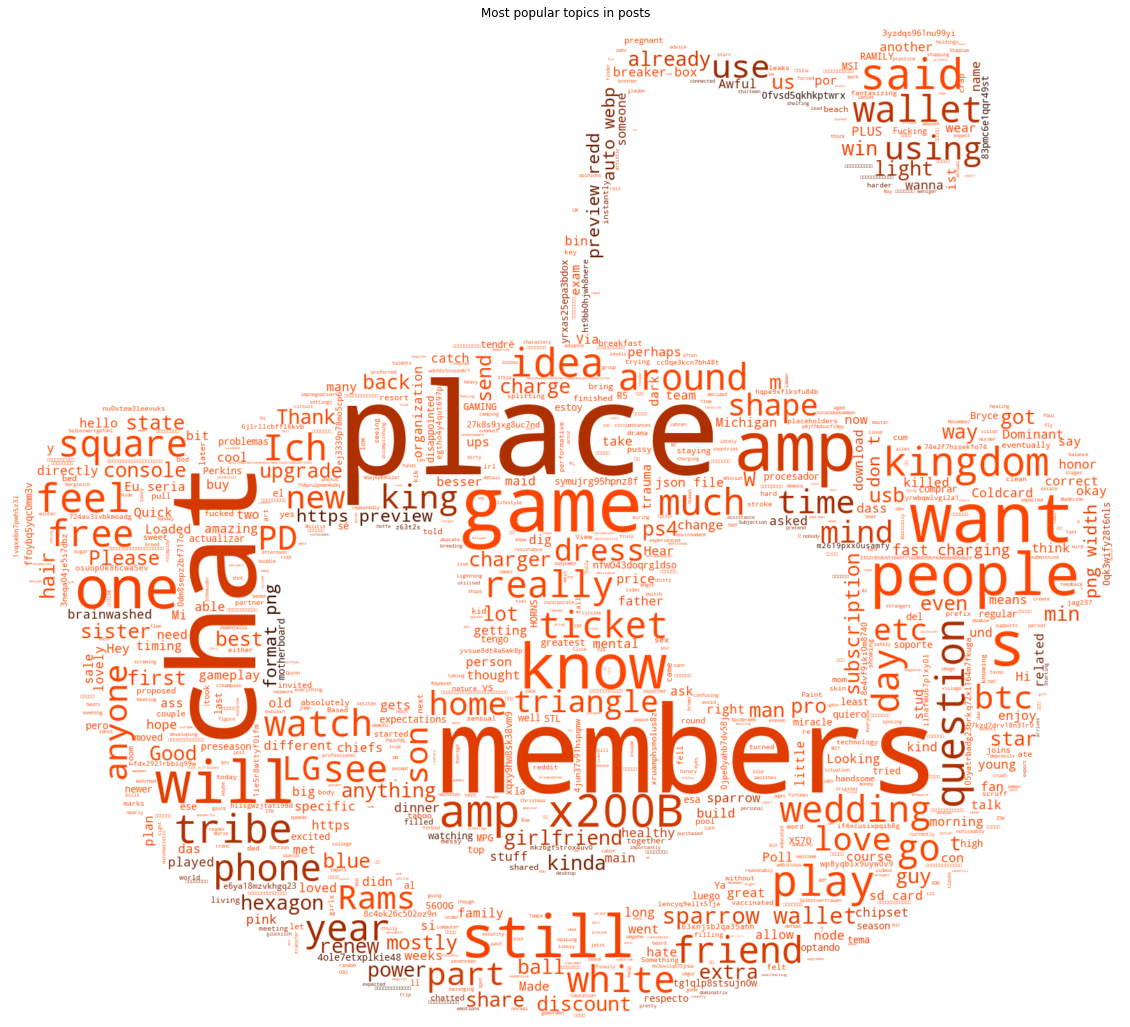

In [226]:
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in posts")
plt.axis("off");

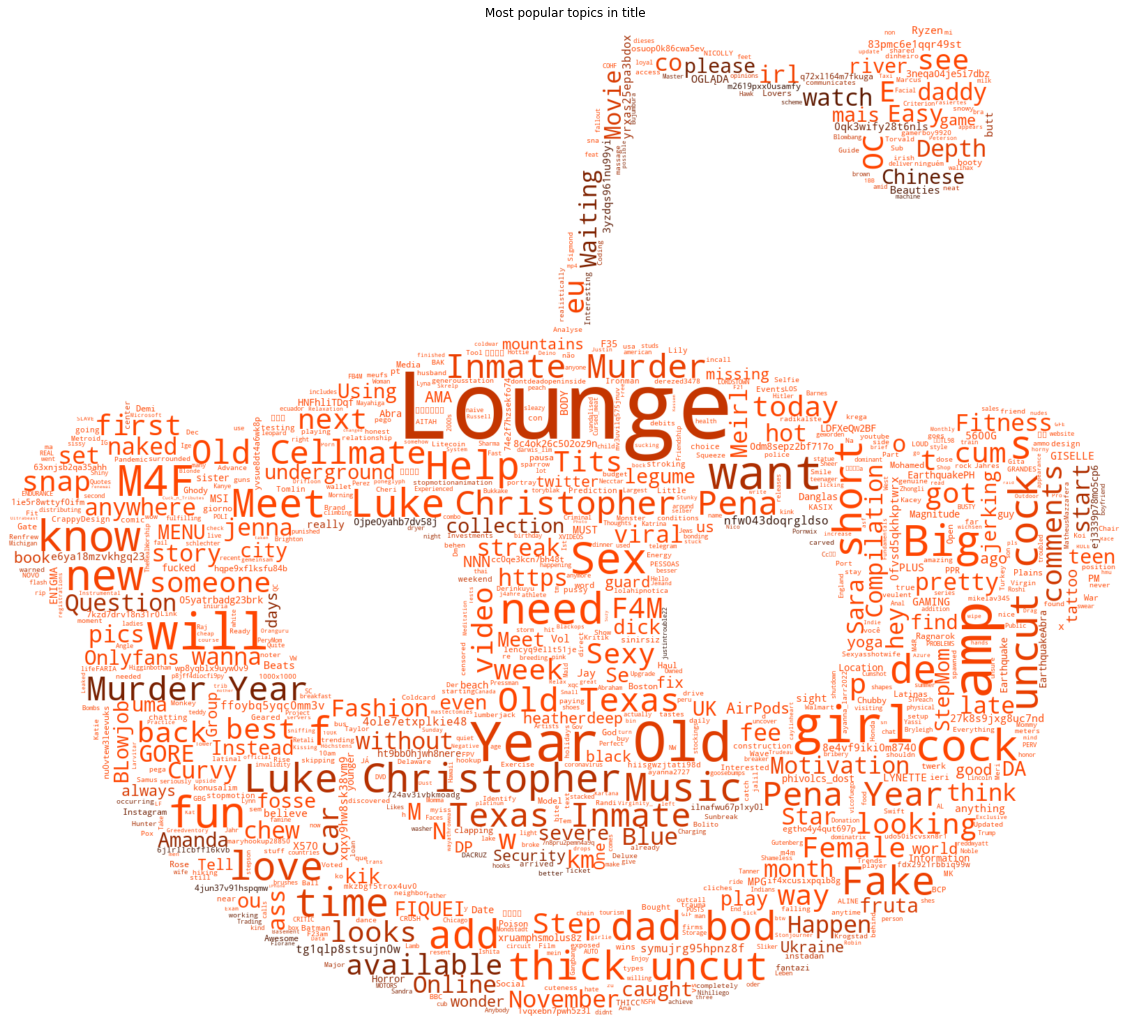

In [227]:
text = " ".join([i for i in kdf.title.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in title")
plt.axis("off");

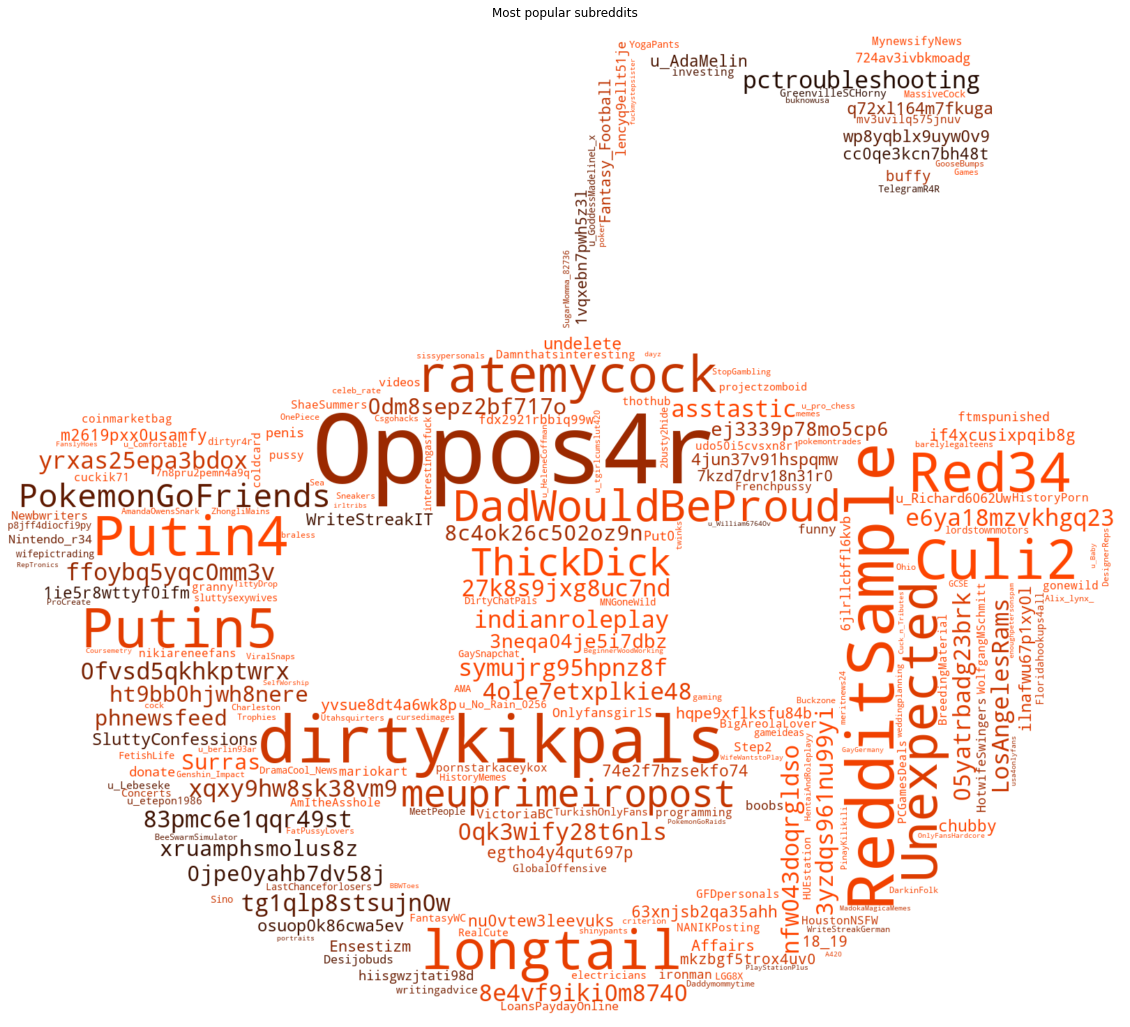

In [228]:
text = " ".join([i for i in kdf.subreddit.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular subreddits")
plt.axis("off");

--------


<font size=10 color=red>Assignment question</font>

Choose a subreddit you like and build a worldcloud using Koalas. Feel free to change the mask or the colors...

--------
Answer:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1189k  100 1189k    0     0  3232k      0 --:--:-- --:--:-- --:--:-- 3232k
space


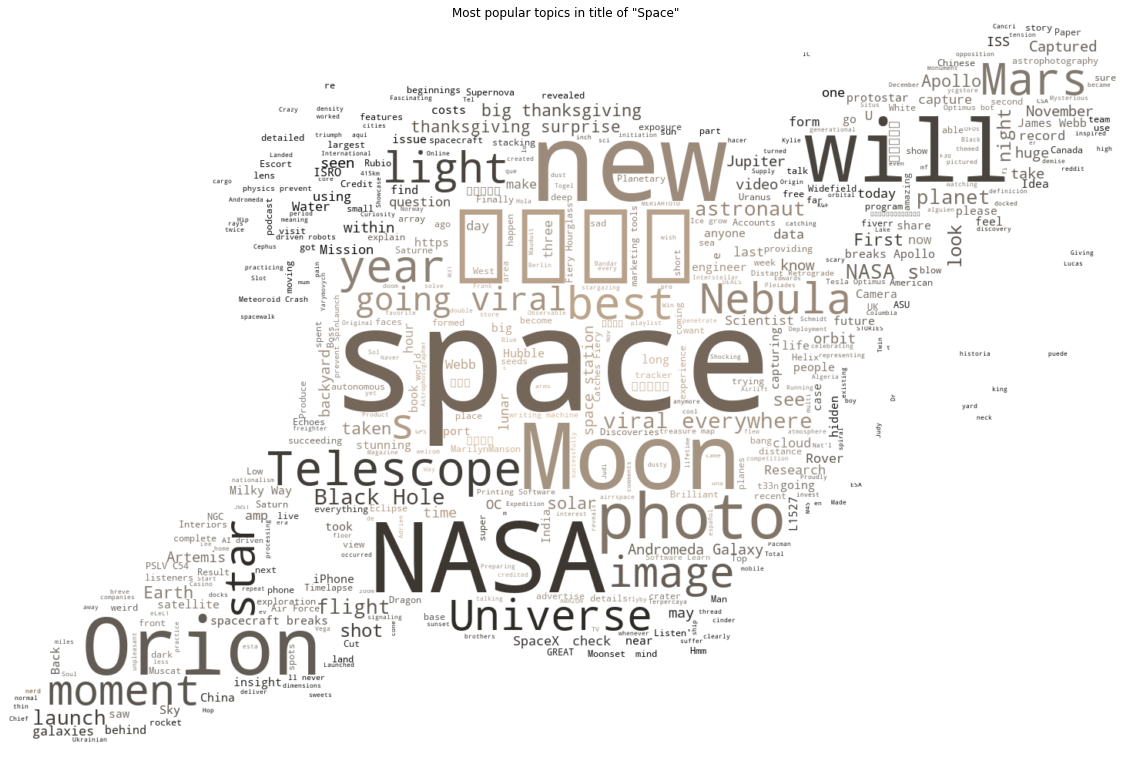

In [255]:
!curl https://upload.wikimedia.org/wikipedia/commons/4/43/Saturnx.png > saturn.png

pdf_space = loadRedditToPandas(subreddit='space', size=100000)
kdf_space = ks.from_pandas(pdf_space[attrs])

mask = np.array(Image.open("/content/saturn.png"))
text = " ".join([i for i in kdf_space.title.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])

wordcloud = WordCloud(max_words=500, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in title of \"Space\"")
plt.axis("off");